# Testing code for cost function "elasticity" on the annulus

In [1]:
%pylab inline

import dionysus

Populating the interactive namespace from numpy and matplotlib


## Constructing the annulus and combuting the cocycle

(-2.086457503545654,
 2.1317218950191053,
 -2.1631623714861514,
 2.151883535225691)

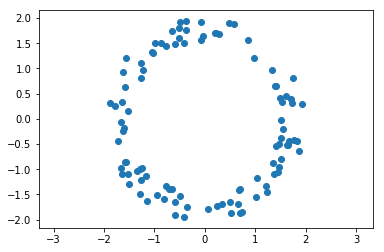

In [2]:
R = 1.5
d = .5
n = 100

# r in [0,1]
# th in [0,2pi)

from math import sin, cos, pi
from random import uniform
def rand_annulus_pt():
    r = uniform(0,1)
    th = uniform(0,2*pi)
    return (R+r*d) * cos(th), (R+r*d) * sin(th)
annulus = np.array([(rand_annulus_pt()) for x in range(100)])
plt.scatter(*annulus.T)
plt.axis('equal')

In [3]:
prime = 19
vr = dionysus.fill_rips(annulus, 2, 4.)
cp = dionysus.cohomology_persistence(vr, prime, True)
dgms = dionysus.init_diagrams(cp, vr)

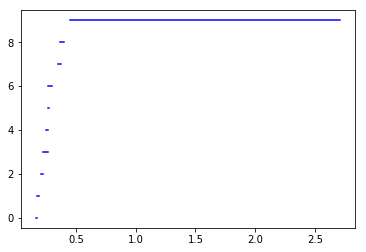

In [4]:
dionysus.plot.plot_bars(dgms[1], show=True)

In [5]:
bars = [bar for bar in dgms[1] if bar.death > 1.]
bars

[(0.453032,2.71235)]

In [6]:
#cocycles = [cp.cocycle(bar.data) for bar in bars]
#vr_8 = dionysus.Filtration([s for s in vr if s.data <= 1.0])
#coords = [dionysus.smooth(vr_8, cocycle, prime) for cocycle in cocycles]

(-2.0570882084951445,
 2.199626142696939,
 -2.1462938955434394,
 2.1901030883462775)

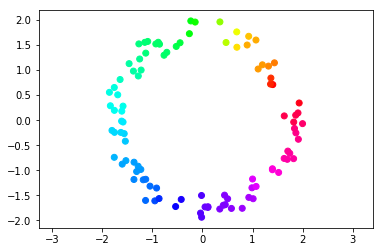

In [7]:
# subplot(121)#, projection="3d")
#scatter(*annulus.T, c=coords[0], cmap="hsv")
#plt.axis('equal')

# subplot(122)#, projection="3d")
# scatter(*annulus.T, c=coords[1], cmap="hsv")

# Scipy Test

In [13]:
import scipy.sparse
D = {}
data = {}
indexing = {}
ix = [0]*50
thr = 3

cocycles = [cp.cocycle(bar.data) for bar in bars]
vr_thr = dionysus.Filtration([s for s in vr if s.data <= thr])
coords = [dionysus.smooth(vr_thr, cocycle, prime) for cocycle in cocycles]

for s in vr_thr:
    if s.dimension() == 0:
        continue
    D.setdefault(s.dimension(),[[],[]])
    data.setdefault(s.dimension(),[])
    indexing.setdefault(s.dimension(),{})
    indexing.setdefault(s.dimension()-1,{})
    if not s in indexing[s.dimension()]:
        indexing[s.dimension()][s] = ix[s.dimension()]
        ix[s.dimension()] += 1
    for dat, k in enumerate(s.boundary()): 
        if not k in indexing[s.dimension()-1]:
            indexing[s.dimension()-1][k] = ix[s.dimension()-1]
            ix[s.dimension()-1] += 1
        D[s.dimension()][0].append(indexing[s.dimension()][s]) #rows
        D[s.dimension()][1].append(indexing[s.dimension()-1][k]) #cols
        data[s.dimension()].append(1. if dat % 2 == 0 else -1.)
import scipy as sp
CBd = [sp.sparse.csr_matrix((data[d], (D[d][0], D[d][1]))).todense() for d in range(1,max(D.keys())+1)]

In [8]:
from scipy.optimize import minimize

In [15]:
l2_cocycle = [0]*len(coords[0])
for i, coeff in enumerate(coords[0]):
    l2_cocycle[indexing[0][dionysus.Simplex([i],0)]] = coeff
l2_cocycle = np.array(l2_cocycle)
bdry = CBd[0]
n, m = CBd[0].shape
f = np.zeros((n,1))
for c2 in cocycles[0]:
    f[indexing[1][vr[c2.index]]] = c2.element

Derive gradient for cost function:

$$
c = \color{blue}{\|f-\delta z\|_2} + \color{green}{\lambda \|\delta z\|_2}
$$

We compute the gradient of each term separately: 

$$
\begin{align*}
\color{blue}{\left[(f-\delta z)^2\right]_j}
  &= f_j^2 - 2 f_j\sum_i \delta_{ji}z_i + \left(\sum_i \delta_{ji}z_i\right)^2 \\
\frac{\partial\|f-\delta z\|_2}{\partial z_k} 
  &= \sum_j\left[0 - 2f_j\delta_{jk}z_k + \frac{\partial}{\partial z_k}\left(\delta_{jk}^2z_k^2 + \sum_{i\neq k} 2\delta_{jk}\delta_{ji}z_kz_i\right)\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}z_k + 2\delta_{jk}^2z_k + \sum_{i\neq k}2\delta_{jk}\delta_{ji}z_i\right] \\
  &= \sum_j\left[-2f_j\delta_{jk}+2\delta_{jk}\sum_i\delta_{ji}z_i\right] \\
  &= \sum_j2\delta_{jk}\left[\sum_i\delta_{ji}z_i-f_jz_k\right]
\end{align*}
$$

And

$$
\begin{align*}
\color{green}{\frac{\partial\|\left[\sum_i\delta_{ji}z_i\right]_j\|_p}{\partial z_k}}
  &= \frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right]^{1/p} \\
  &= (1/p)\left[\sum_j b_j^p\right]^{1/p-1}\frac{\partial}{\partial z_k}\left[\sum_j b_j^p\right] \\
  &= \dots \\
  &= \frac{1}{\|\partial z\|_2}
  \begin{pmatrix}
  \delta_{0k} & \dots & \delta_{nk} 
  \end{pmatrix}
  \begin{pmatrix}
  b_0 \\ \vdots \\ b_n
  \end{pmatrix}
\end{align*}
$$

Combining them both into a matrix form yields

$$
\nabla cost =
\delta^T\delta z \left(2 + \frac{\lambda}{\|\delta z\|_2}\right)-2\text{diag}(z)\delta^T f
\qquad
H cost = \delta^T\delta\left(2+\frac{\lambda}{\|\delta z\|_2}\right) - 2\frac{\lambda}{\|\delta z\|_2^3}\delta^T\delta z (\delta z)^T\delta - 2 \text{diag}(\delta^T f)
$$

In [28]:
def cost(Z,L = 1.,F = f, B = bdry):
    return np.linalg.norm(F - B*Z.reshape(Z.shape[0],1), ord=2) + L*np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)

def grad(Z,L = 1.,F = f, B = bdry):
    coeff_A = 2 + L/np.linalg.norm(B*Z.reshape(Z.shape[0],1),ord=2)
    dz = B*Z.reshape(Z.shape[0],1)
    return np.array(coeff_A * B.T * dz - 2 * np.diag(Z) * B.T * F).flatten()

In [27]:
#grad(l2_cocycle)

In [17]:
cost(l2_cocycle)
# ??dionysus.smooth

301.65649245527555

In [25]:
res = minimize(cost, l2_cocycle, method='BFGS', jac = grad)

Text(0.5, 1.0, 'smoothed values mod 1')

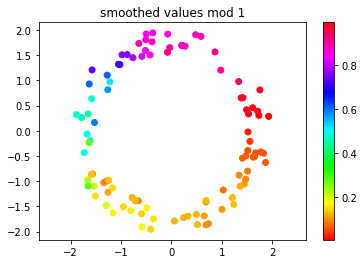

In [26]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = np.mod(Zv.T[:,messed_ix],1)
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values mod 1')

Text(0.5, 1.0, 'smoothed values')

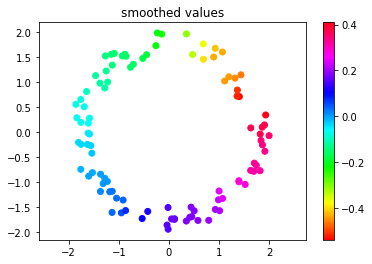

In [132]:
Zv = np.array(res.x).reshape(100,1)
messed_ix = [indexing[0][dionysus.Simplex([n],0)] for n in range(100)]
color = Zv.T[:,messed_ix]
scatter(*annulus.T, c=color[0], cmap="hsv")
plt.colorbar()
plt.axis('equal')
plt.title('smoothed values')